In [1]:
import pandas as pd
import numpy as np
import re
from queue import Queue
from flask import Flask, request, render_template, jsonify
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import json

In [2]:
def get_pos_form_str(S):
    matches = re.findall(r'\d+\.\d+', S)
    first_two_numbers = matches[:2]
    return eval(first_two_numbers[0]), eval(first_two_numbers[1])

def getdis(x1, y1, x2, y2):
    disx = abs(x1 - x2)/0.006641999999999371*1000
    disy = abs(y1 - y2)/0.008443999999997231*1000
    return np.sqrt(disx**2 + disy**2)

def cluster(x, y, z):
    newx = []
    newy = []
    newz = []
    book = []
    # 定义队列
    que = Queue()

    for i in range(len(x)):
        if i in book:
            continue
        book.append(i)
        if z[i] < 20:
            continue
        que.put(i)
        tempx = 0
        tempy = 0
        tempz = 0
        cnt = 0
        
        while not que.empty():
            top = que.get()
            tempx += x[top]
            tempy += y[top]
            tempz += z[top]
            cnt += 1
            for j in range(len(x)):
                if j in book:
                    continue
                if getdis(x[top], y[top], x[j], y[j]) <= 50: #TODO 调整这个阈值
                    book.append(j)
                    que.put(j)

        newx.append(tempx / cnt)
        newy.append(tempy / cnt)
        newz.append(tempz / cnt)
    return newx, newy, newz

def datapreprocessing(x, y, z):
    data = pd.read_excel('files/raw.xlsx')
    for i in range(len(data)):
        x_, y_ = get_pos_form_str(data.iloc[i, 2])
        x.append(x_)
        y.append(y_)
        z.append(data.iloc[i, 1])
    x, y, z = cluster(x, y, z)
    return x, y, z

def get_data():
    data = request.json
    gridx = data.get('gridx')
    gridy = data.get('gridy')
    # 在这里调用相应的函数处理参数，并获取数据
    result = process_data(gridx, gridy)
    # 返回处理后的数据给前端
    return jsonify(result)

def process_data(gridx, gridy):
    # 在这里处理参数并获取数据的逻辑
    Tmp, _ = OK.execute('points', gridx, gridy)
    # 保存到文件
    z = []
    for i in range(len(Tmp)):
        z.append(Tmp[i])
    return z

def getmodel(x, y, z):
    global OK
    OK = OrdinaryKriging(
        x,
        y,
        z,
        variogram_model="spherical",
        variogram_parameters={'psill': 100, 'range': 1, 'nugget': 1},
        verbose=False,
        enable_plotting=False,
        coordinates_type="geographic",
    )

def upload_file():
    uploaded_file = request.files['file']
    if uploaded_file:
        # 处理上传的文件逻辑
        file_path = "files/raw.xlsx"  # 保存文件的路径和名称，注意文件后缀应为.xlsx
        uploaded_file.save(file_path)  # 保存文件到指定路径
        x, y, z = datapreprocessing()
        getmodel(x, y, z)
        print('haha')
        return "文件上传成功"
    else:
        return "未收到文件"

In [3]:
x, y, z = [], [], [] 
x, y, z = datapreprocessing(x, y, z) 
getmodel(x, y, z) 
data = pd.read_csv('files/grid.csv').values 
gridx, gridy = data[:, 0], data[:, 1] 


In [4]:
import tqdm
Minx = 99999
Maxx = -99999
Miny = 99999
Maxy = -99999

for i in range(len(gridx)):
    Minx = min(Minx, gridx[i])
    Maxx = max(Maxx, gridx[i])
    Miny = min(Miny, gridy[i])
    Maxy = max(Maxy, gridy[i])

gridx = np.linspace(Minx, Maxx, 100)
gridy = np.linspace(Miny, Maxy, 100)
gridz = np.zeros((100, 100))

def process_data(gridx, gridy):
    # 在这里处理参数并获取数据的逻辑
    Tmp, _ = OK.execute('points', gridx, gridy)
    # 保存到文件
    try:
        return Tmp[0]
    except:
        pass

Trange = tqdm.trange(100)

for i in Trange:
    for j in range(100):
        gridz[i][j] = process_data(gridx[i], gridy[j])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


Text(0.5, 0, 'z')

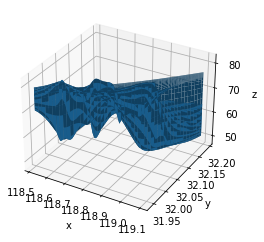

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(gridx, gridy, gridz)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [6]:
Minx, Maxx, Miny, Maxy

(118.51905273050374, 119.095979269497, 31.941147987878043, 32.19171901212196)